# Stellar Classification

Information about dataset:
1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Будем решать задачу классификации на class: galaxy, star, quasar

# 1. Загрузка и предварительная обработка данных

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('star_classification.csv')
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [4]:
sum(df.duplicated())

0

Дубликатов нет

In [5]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

Классы несбалансированы, accuracy плохо отразит результаты, поэтому будем пользоваться ROC AUC

# 2. Обработка датасета

Посмотрим на распределение каждой переменной

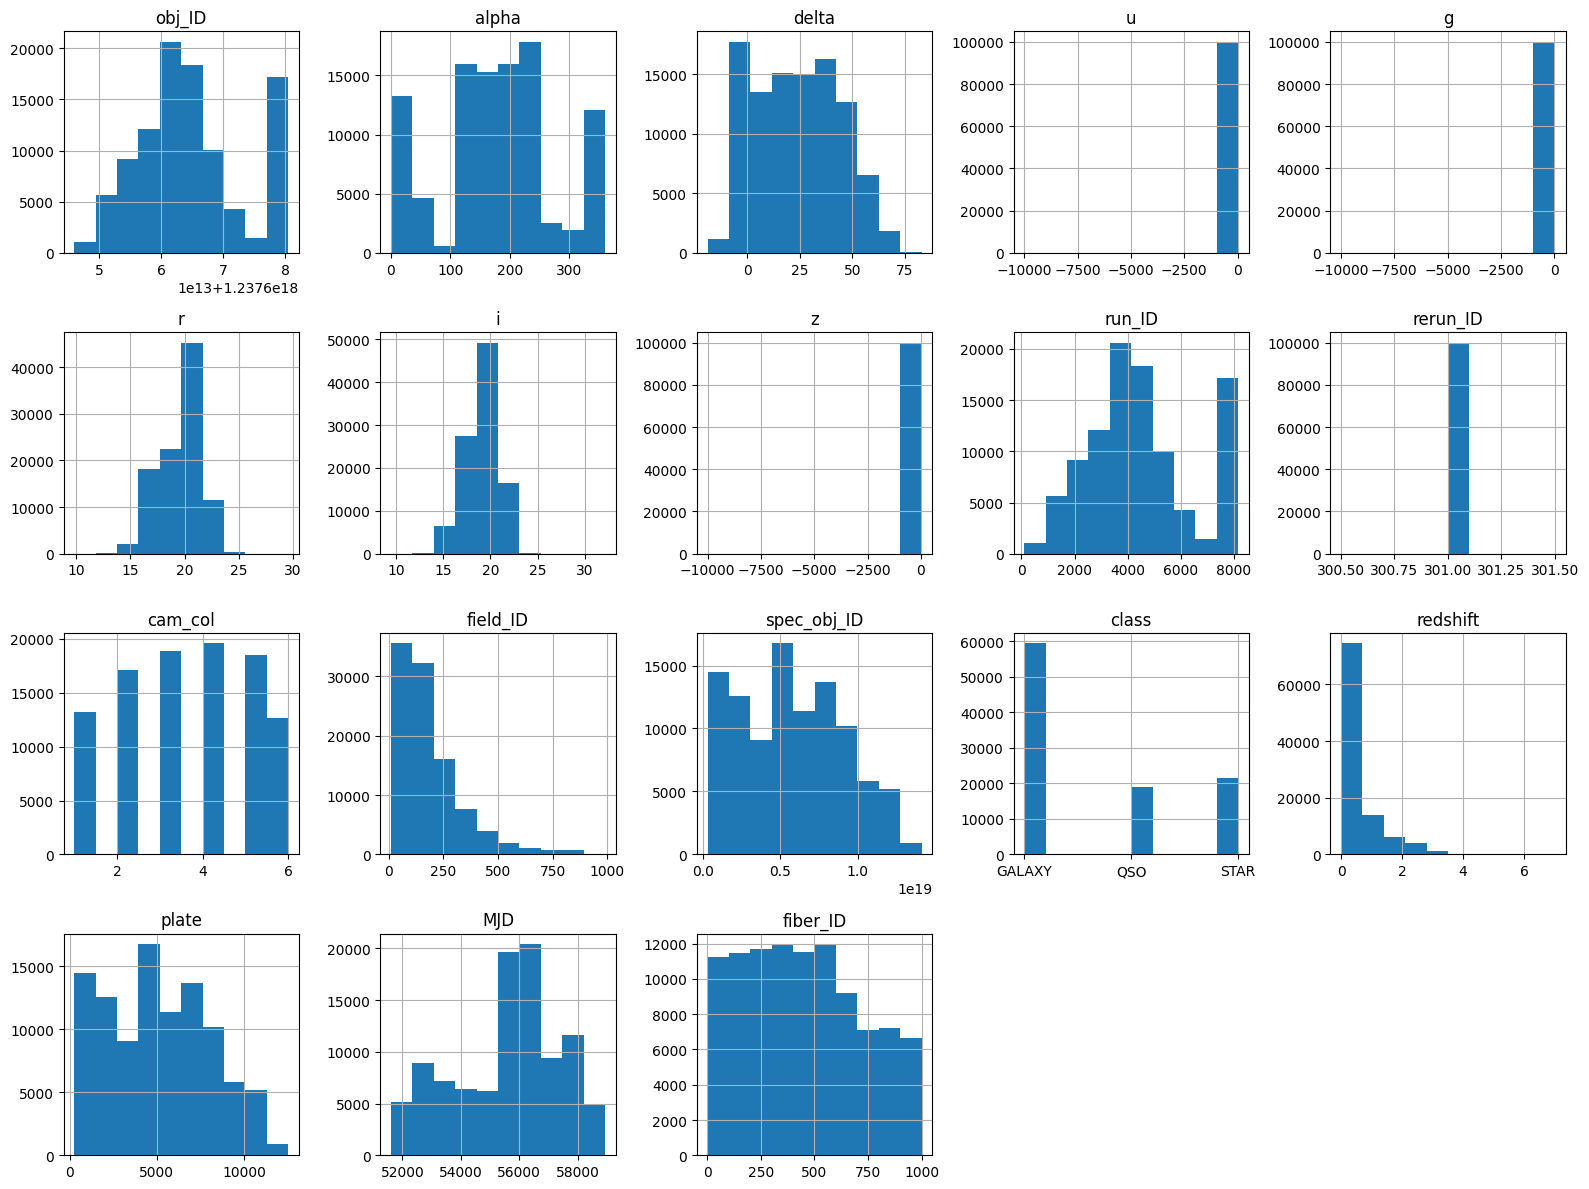

In [6]:
fig, axes= plt.subplots(4,5, figsize=(16,12))
axes = axes.flatten()
for i, c in enumerate(df.columns):
    ax = axes[i]
    df[c].hist(ax=ax)
    ax.set_title(c)

for j in range(len(df.columns), 20):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [ ]:
df['rerun_ID'].value_counts()

rerun_ID
301    100000
Name: count, dtype: int64

Удалим obj_ID, так как он уникален для всех, и rerun_ID, так как он одинаков для всех (=305)

In [ ]:
df.drop(columns=['obj_ID', 'rerun_ID'], inplace=True)

In [15]:
df['cam_col'].value_counts()

cam_col
4    19573
3    18851
5    18537
2    17117
1    13227
6    12695
Name: count, dtype: int64

cam_col будем обрабатывать с помощью get_dummies

Сформируем список колонок которые будем нормировать

In [ ]:
columns_to_scale = list(df.columns)
columns_to_scale.remove('cam_col')
columns_to_scale.remove('class')
columns_to_scale

['alpha',
 'delta',
 'u',
 'g',
 'r',
 'i',
 'z',
 'run_ID',
 'field_ID',
 'spec_obj_ID',
 'redshift',
 'plate',
 'MJD',
 'fiber_ID']

# 3. Построение моделей

In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

LabelEncoder - для кодировки целевой переменной \
StandardScaler - для нормировки количественных признаков

In [41]:
le = LabelEncoder()
sc = StandardScaler()

In [53]:
df_encoded = pd.get_dummies(df, columns=['cam_col'])
df_encoded.drop(columns=['cam_col_1'], inplace=True)

In [54]:
x = df_encoded.drop(columns=['class'])
y = df_encoded['class']

In [55]:
y = le.fit_transform(y)
x[columns_to_scale] = sc.fit_transform(df[columns_to_scale])

In [56]:
x

,alpha,delta,u,g,r,i,z,run_ID,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,cam_col_2,cam_col_3,cam_col_4,cam_col_5,cam_col_6
0,-0.434604,0.425529,0.059755,0.054926,0.403962,0.046007,0.003937,-0.445535,-0.718947,0.228609,0.079557,0.228633,0.423203,-1.021342,True,False,False,False,False
1,-0.339921,0.363402,0.088045,0.072456,1.584406,1.185097,0.092835,0.018646,-0.450509,1.797912,0.277096,1.797924,1.420729,-0.081883,False,False,False,True,False
2,-0.367251,0.582713,0.103327,0.067165,0.519745,0.150019,0.008808,-0.445535,-0.443798,-0.190037,0.092423,-0.190025,0.001854,-0.551612,True,False,False,False,False
3,1.669523,-1.249105,0.004921,0.102210,1.059904,0.807610,0.018321,-0.147278,0.187031,1.358962,0.486770,1.358942,1.354927,1.195196,False,True,False,False,False
4,1.737310,-0.150242,-0.080055,-0.092948,-1.697421,-1.767887,-0.098468,1.842792,-0.329712,0.333328,-0.630267,0.333297,0.330860,1.441070,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1.430113,-1.360650,0.005890,0.076991,1.217564,1.263237,0.065144,1.677886,2.649947,1.435146,-0.789186,1.435155,1.194571,-0.041515,True,False,False,False,False
99996,-1.535053,-0.220744,0.022371,0.058422,0.433626,0.382696,0.023527,1.748632,0.690351,0.843101,-0.235069,0.843071,0.743915,1.529144,False,False,False,False,False
99997,0.486606,-0.429360,-0.025538,-0.039730,-0.777184,-0.793290,-0.041496,0.423785,0.817859,-0.803813,-0.592984,-0.803786,-0.582617,-1.377309,False,False,True,False,False
99998,0.358952,1.146631,0.106075,0.034840,0.144547,-0.007005,-0.001386,-0.423140,-0.369978,0.546690,-0.166444,0.546691,0.430945,0.075917,False,False,True,False,False


In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## 3.1. Модели с параметрами по умолчанию

Будем использовать случайный лес (бэггинг), XGBoost, LightGBMBoost (градиентный бутинг)

In [81]:
rf = RandomForestClassifier()
xg = XGBClassifier()
lg = LGBMClassifier()

In [74]:
rf.fit(x_train, y_train)
xg.fit(x_train, y_train)
lg.fit(x_train, y_train)

LGBMClassifier()

Будем считать метрику ROC AUC

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
rf_pred = rf.predict_proba(x_test)
xg_pred = xg.predict_proba(x_test)
lg_pred = lg.predict_proba(x_test)

In [78]:
rf_roc = roc_auc_score(y_test, rf_pred, multi_class='ovr')
xg_score = roc_auc_score(y_test, xg_pred, multi_class='ovr')
lg_score = roc_auc_score(y_test, lg_pred, multi_class='ovr')

In [79]:
print(rf_roc, xg_score, lg_score)

0.9941922932501613 0.9951560576402215 0.9952230610793982


Результат ROC AUC:
1. RandomForest: 0.994192
2. XGBoost: 0.995156
3. LightGBM: 0.995223

Лучшая модель: LightGBM

## 3.2. Подбор параметров моделей

С помощью GridSearchCV будем подбирать параметры для каждой модели

### 3.2.1. RandomForest

In [82]:
params_rf = { 'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'criterion': ['gini', 'log_loss', 'entropy']} 
grid_search_rf = GridSearchCV(rf, params_rf, cv=3, scoring='roc_auc_ovr')
grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc_ovr')

In [87]:
y_rf_pred = grid_search_rf.best_estimator_.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_rf_pred, multi_class='ovr')
print(roc_auc)

0.9947138641840944


Лучшая модель с параметрами: 
1. criterion = 'entropy'
2. max_depth = 20
3. n_estimators = 150 

ROC AUC: 0.994713 

Реультат лучше чем у модели с параметрами по умолчанию: 
1. criterion = 'gini'
2. max_depth = None
3. n_estimators = 100

### 3.2.2. XGBoost

In [88]:
params_xg = { 'reg_lambda': [0, 1, 10], 'reg_alpha': [0, 1, 10], 'learning_rate': [0.01, 0.1, 0.2]} 
grid_search_xg = GridSearchCV(xg, params_xg, cv=3, scoring='roc_auc_ovr')
grid_search_xg.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'reg_alpha': [0, 1, 10], 'reg_lambda': [0, 1, 10]},
             scoring='roc_auc_ovr')

In [89]:
y_xg_pred = grid_search_xg.best_estimator_.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_xg_pred, multi_class='ovr')
print(roc_auc)

0.9951124901180882


In [98]:
print(grid_search_xg.best_estimator_.get_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 10, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [96]:
print(xg.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Лучшая модель с параметрами: 
1. reg_lambda = 1
2. reg_alpha = 10
3. learning_rate = 0.2 

ROC AUC: 0.995112

Реультат хуже чем у модели с параметрами по умолчанию: 
1. reg_lambda = None
2. reg_alpha = None
3. learning_rate = None

### 3.2.3. LightGBM

In [90]:
params_lg = { 'min_child_samples': [10, 20, 50], 'num_leaves': [31, 50, 100], 'max_depth': [-1, 10, 20]} 
grid_search_lg = GridSearchCV(lg, params_lg, cv=3, scoring='roc_auc_ovr')
grid_search_lg.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'max_depth': [-1, 10, 20],
                         'min_child_samples': [10, 20, 50],
                         'num_leaves': [31, 50, 100]},
             scoring='roc_auc_ovr')

In [91]:
y_lg_pred = grid_search_lg.best_estimator_.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_lg_pred, multi_class='ovr')
print(roc_auc)

0.9953945821988812


In [99]:
print(grid_search_lg.best_estimator_.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 100, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [100]:
print(lg.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Лучшая модель с параметрами: 
1. min_child_samples = 20
2. num_leaves = 100
3. max_depth = 20

ROC AUC: 0.995394 

Реультат лучше чем у модели с параметрами по умолчанию: 
1. min_child_samples = 20
2. num_leaves = 31
3. max_depth = -1

# 4. Вывод

Лучшей моделью среди всех оказалась LightGBM с парметрами:
1. min_child_samples = 20
2. num_leaves = 100
3. max_depth = 20

ROC AUC: 0.995394
